In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd 

# define csv read
def read_data2(filename):
    # read in csv
    df = pd.read_csv(filename)
    
    df = df.drop('Unnamed: 0', axis = 1)
    return df

# load cleaned file with sentiment data
new = read_data2('/content/drive/MyDrive/updated_bias_articles.csv')
new.head()

,Title,Text,Source,Bias,Sentences,Reading,Length
0,Michigan wants to lead U.S. in electric vehicl...,The Dearborn-based automaker chose Tennessee f...,Bridgemi,4,52,72.0,1248
1,Republicans’ hold on Lansing power could grow ...,"From a purely geographic perspective, most of ...",Bridgemi,4,17,84.3,331
2,Dueling gatherings highlight split as Michigan...,“The focus of the last election is always goin...,Bridgemi,4,21,29.2,371
3,Michigan counties dump mask rules for thousand...,"Marquette, Ottawa, Washtenaw and Kent county h...",Bridgemi,4,82,36.3,1500
4,Gov. Gretchen Whitmer signs $70B Michigan budg...,"The finalized legislation, brokered by Whitmer...",Bridgemi,4,66,41.7,1363


In [ ]:
len(set(new['Source'].values.tolist()))

12

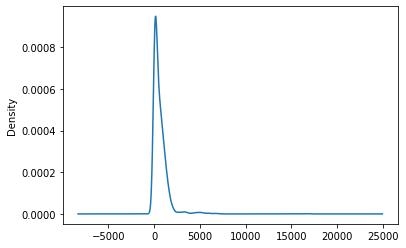

In [ ]:
new.Length.plot.kde()

In [ ]:
from scipy import stats
print(stats.describe(new.Length))

DescribeResult(nobs=1732, minmax=(7, 16618), mean=626.1206697459585, variance=743412.6653841843, skewness=6.231076225651113, kurtosis=79.35731454563724)


In [ ]:
print('Under 20 words: ', len(new[new.Length < 20]))
print('Over 3000 words: ', len(new[new.Length > 3000]))

Under 20 words:  24
Over 3000 words:  36


In [ ]:
new = new[new.Length > 20]
new = new[new.Length < 3000]

In [ ]:
new = new.sample(frac=1).reset_index(drop=True)
new.head()

,Title,Text,Source,Bias,Sentences,Reading,Length
0,Delta increases COVID-19 risks for pregnant wo...,The following is a summary of some recent stud...,Channel News,4,34,23.9,731
1,Teacher catches mother bear and cub playing on...,Even bears like to play.\n\nA teacher in North...,FOX,1,17,28.6,340
2,A daily pill to treat COVID could be just mont...,Within a day of testing positive for COVID-19 ...,The Star,1,72,25.6,1384
3,Britney Spears' father suspended as her conser...,LOS ANGELES — A judge in Los Angeles ruled Wed...,NBC,2,82,30.8,1562
4,How Kate Middleton's 'No Time to Die' premiere...,Kate Middleton made headlines on Tuesday for h...,FOX,1,13,57.6,339


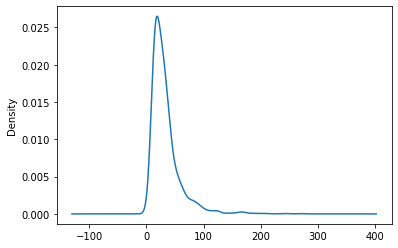

In [ ]:
new.Reading.plot.kde()

In [ ]:
new['Reading'].groupby(new['Bias']).describe()

,count,mean,std,min,25%,50%,75%,max
Bias,,,,,,,,
1,549.0,31.537341,23.898399,5.3,16.900,25.50,37.400,208.6
2,432.0,25.592361,16.011035,2.8,15.025,21.75,31.925,170.3
3,114.0,36.834211,34.538848,7.1,15.450,25.30,49.025,243.6
4,568.0,39.665845,30.942778,4.9,20.175,30.80,47.500,269.1


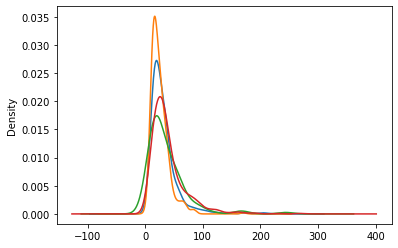

In [ ]:

new['Reading'].groupby(new['Bias']).plot.kde();

In [ ]:

print('Left: ', new.loc[new['Bias'] == 1].shape[0])
print('Center: ', new.loc[new['Bias'] == 2].shape[0])
print('Lean Right: ', new.loc[new['Bias'] == 3].shape[0])
print('Right: ', new.loc[new['Bias'] == 4].shape[0])

Left:  549
Center:  432
Lean Right:  114
Right:  568


In [ ]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
def get_text(X):
  return X['Text'].values

# get source function
def get_source(X):
  return X['Source'].values

# get bias function
def get_bias(y):
  return y['Bias'].values

In [ ]:
from sklearn.svm import LinearSVC

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('get_text', FunctionTransformer(get_text, validate=False)),
            ('tfidf', TfidfVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.8, min_df = 0.03, sublinear_tf=True, norm='l2' )), 
        ])),
        ('source', Pipeline([
            ('get_text', FunctionTransformer(get_source, validate=False)),
            ('tfidf2', TfidfVectorizer(ngram_range=(1,5), sublinear_tf=True, norm='l2' )), 
        ])),
      ],
        # weight components in FeatureUnion
        transformer_weights={
            'text': 0.5,
            'source': 0.5,
        },
    )),
  
    ('clf', OneVsRestClassifier(LinearSVC()))])

In [ ]:
from sklearn.model_selection import train_test_split

# subset data frame into features and outcomes
features = new.loc[:, ['Text', 'Source']]
outcomes = new.loc[:, ['Bias']]


X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.2)
y_train, y_test = get_bias(y_train), get_bias(y_test)

In [ ]:
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)


In [ ]:
accuracy = np.mean(predicted == y_test)*100.0
print(accuracy)

100.0


In [ ]:
def get_sentences(X):
  num_sent = X['Sentences']
  return np.array(num_sent).reshape(-1, 1)

# get text length
def get_text_len(X):
  text_len = X['Length'].values
  return np.array(text_len).reshape(-1, 1)

# get readability
def get_read(X):
  read = X['Reading'].values
  return np.array(read).reshape(-1, 1)

In [ ]:
from sklearn.svm import LinearSVC

classifier2 = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('get_text', FunctionTransformer(get_text, validate=False)),
            ('tfidf', TfidfVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.3, min_df = 0.01, sublinear_tf=True, norm='l2' )), 
        ])),
      
      
        ('sentences', Pipeline([
            ('get_sentences', FunctionTransformer(get_sentences, validate=False)),
        ])),
      
        ('read', Pipeline([
            ('get_read', FunctionTransformer(get_read, validate=False)),
        ])),
      
      ],
        # weight components in FeatureUnion
        transformer_weights={
            'text': 0.8,
            'sentences':0.4,
            'read':1,
            
        },
    )),
  
    ('clf', OneVsRestClassifier(LinearSVC()))])

In [ ]:
# create training and test sets
from sklearn.model_selection import train_test_split

In [ ]:
features = new.loc[:, ['Text','Sentences', 'Reading']]
outcomes = new.loc[:, ['Bias']]

X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.2)
y_train, y_test = get_bias(y_train), get_bias(y_test)

In [ ]:
classifier2.fit(X_train, y_train)
predicted = classifier2.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
accuracy = np.mean(predicted == y_test)
print(accuracy)

0.7567567567567568


In [ ]:
from sklearn.model_selection import StratifiedKFold

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=8, shuffle=True)

# Loop through the indices the split() method returns
cum_val = []

for index, (train_indices, val_indices) in enumerate(skf.split(features, outcomes)):
    print("Training on fold ", str(index+1), "/8...")
    
    # Generate batches from indices
    xtrain, xval = features.iloc[train_indices], features.iloc[val_indices]
    ytrain, yval = outcomes.iloc[train_indices], outcomes.iloc[val_indices]
    
    # Debug message
    print("Training new iteration on ", str(xtrain.shape[0]), " training samples, ", str(xval.shape[0]), " validation samples, this may be a while...")
    
    classifier2.fit(xtrain, ytrain)
    
    train_pred = classifier2.predict(xtrain)
    train_accuracy = np.mean(train_pred == ytrain['Bias'].values)    
    
    val_pred = classifier2.predict(xval)
    val_accuracy = np.mean(val_pred == yval['Bias'].values)
    
    cum_val.append(val_accuracy)
    cum_acc = np.mean(cum_val)
    
    print("Last training accuracy: ", str(train_accuracy), ", last validation accuracy: ", str(val_accuracy))
    print("Stratified 8-fold validation accuracy: ", str(cum_acc))


Training on fold  1 /8...
Training new iteration on  1455  training samples,  208  validation samples, this may be a while...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Last training accuracy:  0.9656357388316151 , last validation accuracy:  0.7836538461538461
Stratified 10-fold validation accuracy:  0.7836538461538461
Training on fold  2 /8...
Training new iteration on  1455  training samples,  208  validation samples, this may be a while...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Last training accuracy:  0.9656357388316151 , last validation accuracy:  0.7740384615384616
Stratified 10-fold validation accuracy:  0.7788461538461539
Training on fold  3 /8...
Training new iteration on  1455  training samples,  208  validation samples, this may be a while...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Last training accuracy:  0.9512027491408934 , last validation accuracy:  0.7355769230769231
Stratified 10-fold validation accuracy:  0.764423076923077
Training on fold  4 /8...
Training new iteration on  1455  training samples,  208  validation samples, this may be a while...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Last training accuracy:  0.934020618556701 , last validation accuracy:  0.7307692307692307
Stratified 10-fold validation accuracy:  0.7560096153846154
Training on fold  5 /8...
Training new iteration on  1455  training samples,  208  validation samples, this may be a while...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Last training accuracy:  0.9099656357388316 , last validation accuracy:  0.6826923076923077
Stratified 10-fold validation accuracy:  0.7413461538461539
Training on fold  6 /8...
Training new iteration on  1455  training samples,  208  validation samples, this may be a while...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Last training accuracy:  0.9656357388316151 , last validation accuracy:  0.7932692307692307
Stratified 10-fold validation accuracy:  0.75
Training on fold  7 /8...
Training new iteration on  1455  training samples,  208  validation samples, this may be a while...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Last training accuracy:  0.9147766323024055 , last validation accuracy:  0.6730769230769231
Stratified 10-fold validation accuracy:  0.739010989010989
Training on fold  8 /8...
Training new iteration on  1456  training samples,  207  validation samples, this may be a while...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Last training accuracy:  0.9615384615384616 , last validation accuracy:  0.7584541062801933
Stratified 10-fold validation accuracy:  0.7414413786696396


In [ ]:
from sklearn.model_selection import learning_curve

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(classifier2, features, outcomes,
                                                        # Number of folds in cross-validation
                                                        cv=8,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

In [ ]:
from matplotlib import pyplot as plt

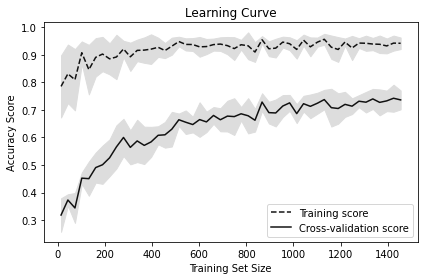

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           1       0.75      0.77      0.76       106
           2       0.69      0.54      0.60        84
           3       0.90      0.82      0.86        22
           4       0.77      0.88      0.82       121

    accuracy                           0.76       333
   macro avg       0.78      0.75      0.76       333
weighted avg       0.75      0.76      0.75       333



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted)

array([[ 82,  11,   0,  13],
       [ 18,  45,   2,  19],
       [  2,   2,  18,   0],
       [  7,   7,   0, 107]])

In [ ]:

import matplotlib.pyplot as plt
import itertools

class_names = ['Left','Center','Lean Right','Right']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.77 0.1  0.   0.12]
 [0.21 0.54 0.02 0.23]
 [0.09 0.09 0.82 0.  ]
 [0.06 0.06 0.   0.88]]


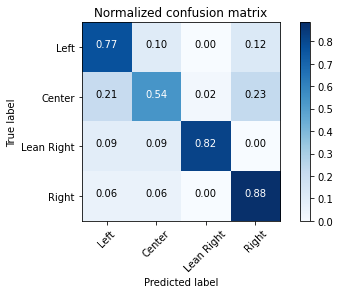

In [ ]:
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()